<img src="https://www.escoladnc.com.br/wp-content/uploads/2022/06/dnc_formacao_dados_logo_principal_preto-1.svg" alt="drawing" width="300"/>

# Recomendação baseada em similaridade de conteúdo - Partes 1 e 2

Este notebook contém a implementação de uma recomendação item-item baseada na similaridade de conteúdo. 

**O notebook é dividido em 2 partes**:

1. Representação vetorial com _one-hot-encoding_
2. Representação vetorial com _PCA_

Ambas as partes se utilizam do mesmo pré-processamento.

In [1]:
import os
import json
import numpy as np
import pandas as pd
# from google.colab import files
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])

# Carregando o dataset

O dataset a ser utilizado (`steam_games.parquet`) contém metadados de 32k jogos da [_Steam_](https://store.steampowered.com/), como:

- `id`: identificador do jogo
- `title`: título do jogo
- `genres`: lista com os gêneros associados ao jogo
- `tags`: lista com tags associadas ao jogo
- `specs`: especificações do jogo
- `release_date`: data de lançamento do jogo
- `price`: preço do jogo
- `sentiment`: avaliação qualitativa do jogo segundo usuários


Upload file `steam_games.parquet`

In [2]:
# %%time
# _ = files.upload()

In [3]:
filepath = '../../../../data/steam_games.parquet'
df = pd.read_parquet(filepath)
df.set_index('id', inplace=True)
df.tail()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
id,,,,,,,,,,,,,,,
773640,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,"Nikita ""Ghost_RUS""",None,nan
733530,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,Sacada,None,nan
610660,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,Laush Dmitriy Sergeevich,None,nan
658870,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,"xropi,stev3ns",1 user reviews,nan
681550,None,None,Maze Run VR,None,http://store.steampowered.com/app/681550/Maze_...,None,"[Early Access, Adventure, Indie, Action, Simul...",NaN,http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,True,None,Positive,nan


# Pré-processamento

Para criarmos uma representação vetorial de cada jogo precisamos processar as _features_ de interesse.

In [4]:
df_features = df.copy()

## Release Year
Extraindo o ano de lançamento do campo `release_date`

In [5]:
import re
def extract_year(release_date):
    if type(release_date) == str and re.match('^\d{4}-\d{2}-\d{2}$', release_date):
        return release_date.split('-')[0]

df_features['release_year'] = df_features['release_date'].apply(extract_year)
df_features[['release_date', 'release_year']].head()

,release_date,release_year
id,,
761140,2018-01-04,2018
643980,2018-01-04,2018
670290,2017-07-24,2017
767400,2017-12-07,2017
773570,None,None


## Price
Convertendo o campo `price` para o tipo _float_

In [6]:
def convert_price(price):
    try:
        return float(price)
    except:
        return 0.0
df_features['price_'] = df_features['price'].apply(convert_price)
df_features[['price', 'price_']].head()

,price,price_
id,,
761140,4.99,4.99
643980,Free To Play,0.00
670290,Free to Play,0.00
767400,0.99,0.99
773570,2.99,2.99


## Sentiment
Categorizando o campo `sentiment`

In [7]:
sentiment_map = {
    'Overwhelmingly Positive': 4,
    'Very Positive': 3,
    'Mostly Positive': 2,
    'Positive': 1,
    'Mixed': 0,
    'Negative': -1,
    'Mostly Negative': -2,
    'Very Negative': -3,
    'Overwhelmingly Negative': -4
}
df_features['sentiment_'] = df_features['sentiment'].map(sentiment_map).fillna(0)
df_features[['sentiment', 'sentiment_']].head()

,sentiment,sentiment_
id,,
761140,None,0.0
643980,Mostly Positive,2.0
670290,Mostly Positive,2.0
767400,None,0.0
773570,None,0.0


## Tags e Specs
Aplicando _one-hot-encoding_ (ou representação maximamente esparsa) para os campos de lista `tags` e `specs`.

**Nota**: o campo `genres` não será utilizado pois suas informações já estão contidas no campo `tags`.

In [8]:
def clean_list_column(list_column):
    return list_column if type(list_column) == list else []

# df_features['tags_'] = df_features['tags'].apply(clean_list_column)
# df_features['specs_'] = df_features['specs'].apply(clean_list_column)

df_tags = pd.get_dummies(df_features['tags'].explode()).groupby('id').max()
df_specs = pd.get_dummies(df_features['specs'].explode()).groupby('id').max()

df_tags.head()

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
id,,,,,,,,,,,,,,,,,,,,,
10,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100400,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10090,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
100980,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
BASE_FEATURES = ['price_', 'sentiment_', 'release_year']
df_train = df_features[BASE_FEATURES].merge(df_tags, left_index=True, right_index=True)
df_train = df_train.merge(df_specs, left_index=True, right_index=True)
df_train.tail()

,price_,sentiment_,release_year,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
9970,9.99,-2.0,2011,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99700,9.99,3.0,2011,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9980,6.99,0.0,2010,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99900,0.00,3.0,2011,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
99910,0.00,3.0,2011,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False


# Parte 1: Representação vetorial simples

A representação vetorial mais simples que podemos fazer é aquela que consideramos todas as _features_ **sem qualquer redução de dimensionalidade**. No entanto, para realizarmos o cálculo da similaridade, é recomendável que os dados estejam normalizados para que uma _feature_ não tenha maior impacto do que a outra no cálculo da similaridade.

Para fazermos a normalização dos dados, utilizaremos as seguintes classes:

- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): escalona as features para o intervalo [0, 1].
- [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html): preenche valores nulos com a média da _feature_.
- [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): agrega todas as transformações em um só objeto.

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

pipeline.fit(df_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

In [11]:
def generate_vector_representation(pipeline:Pipeline, preprocessed_data:pd.DataFrame, keep_columns=True):
    df_vectors = pd.DataFrame(pipeline.transform(preprocessed_data))
    if keep_columns:
        df_vectors.columns = preprocessed_data.columns
    df_vectors.index = preprocessed_data.index
    df_vectors.index.name = 'id'
    return df_vectors
df_vectors = generate_vector_representation(pipeline, df_train)
df_vectors.tail()

,price_,sentiment_,release_year,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
9970,0.012945,0.250,0.836735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99700,0.012945,0.875,0.836735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9980,0.009058,0.500,0.816327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99900,0.000000,0.875,0.836735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99910,0.000000,0.875,0.836735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Observação:** note a quantidade de _features_ na representação vetorial

## Calculando a matriz de similaridade item-item

Uma vez obtida a representação vetorial de cada item, podemos calcular a matriz de similaridades a partir de uma função de calcula a similaridade entre 2 vetores. Neste notebook utilizaremos a **similaridade cosseno** porém outras funções podem ser consultadas na [documentação de métricas pairwise](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise).

In [12]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity_matrix(vectors:pd.DataFrame, similarity_fn=cosine_similarity):
    similarity_matrix = pd.DataFrame(similarity_fn(vectors))
    similarity_matrix.index = vectors.index.astype(str)
    similarity_matrix.index.name = 'id'
    similarity_matrix.columns = vectors.index.astype(str)
    return similarity_matrix

df_item_similarity_matrix = calculate_similarity_matrix(df_vectors)
df_item_similarity_matrix.iloc[:5, :5]

CPU times: user 10.3 s, sys: 2.88 s, total: 13.1 s
Wall time: 3.83 s


id,10,1002,100400,10090,100980
id,,,,,
10,1.000000,0.253148,0.145029,0.391773,0.154565
1002,0.253148,1.000000,0.226340,0.336925,0.233593
100400,0.145029,0.226340,1.000000,0.147372,0.705245
10090,0.391773,0.336925,0.147372,1.000000,0.154867
100980,0.154565,0.233593,0.705245,0.154867,1.000000


## Gerando recomendações

Uma vez obtida a matriz de similaridade item-item, a recomendação pode ser feita obtendo-se os N items mais similares a um _seed_ (ou item-alvo). Portanto, a função `recommend_similar_items()` recebe como parâmetros:

- `similarity_matrix`: matriz com similaridades pre-computadas.
- `target_id`: ID do item-alvo que será a base das recomendações.
- `N`: a quantidade de itens a serem recomendados.

A saída da função é o conjunto de `id`s dos itens recomendados e o `score` de similaridade.

In [13]:
id = '12180'  # Grand Theft Auto 2 

def recommend_similar_items(similarity_matrix:pd.DataFrame, target_id:str, n=10):
    target_item_similarities = similarity_matrix.loc[target_id]
    id_similar_items = (
        target_item_similarities
        .sort_values(ascending=False)
        .reset_index()
        .rename({'index': 'id', target_id: 'score'}, axis=1)
    )
    return id_similar_items.head(n).set_index('id')

df_recommended_items = recommend_similar_items(df_item_similarity_matrix, id)
df_recommended_items

,score
id,
12180,1.000000
12170,0.704370
38430,0.669960
40990,0.647127
2610,0.628885
38490,0.626514
901147,0.621112
6850,0.609481
6880,0.607819


Para facilitar a análise, agregamos os metadados do catálogo e ordenamos por `score`.

**Nota**: o item-alvo intencionalmente aparecerá em 1o lugar pois a similaridade de um item com ele mesmo será sempre máxima. No entanto, em ambientes de produção este item deve ser filtrado da recomendação.

In [14]:
def display_recommendations(recommendations:pd.DataFrame, catalog:pd.DataFrame):
    return (
        recommendations
        .merge(catalog, left_index=True, right_index=True, how='inner')
        .sort_values(by='score', ascending=False)
    )

display_recommendations(df_recommended_items, df[['title', 'tags']])

,score,title,tags
id,,,
12180,1.000000,Grand Theft Auto 2,"[Action, Classic, Open World, Singleplayer, Sh..."
12170,0.704370,Grand Theft Auto,"[Action, Classic, Open World, Singleplayer, 2D..."
38430,0.669960,Kingpin — Life of Crime,"[Action, FPS, Singleplayer, Crime, Classic, Go..."
40990,0.647127,Mafia,"[Action, Adventure, Violent, Story Rich, Class..."
2610,0.628885,GUN™,"[Western, Action, Open World, Third-Person Sho..."
38490,0.626514,Earthworm Jim 2,"[Adventure, Action, Classic, Platformer, 2D]"
901147,0.621112,Earthworm Jim,"[Action, Adventure, Platformer, Classic, 2D]"
6850,0.609481,Hitman 2: Silent Assassin,"[Stealth, Action, Third Person, Singleplayer, ..."
6880,0.607819,Just Cause,"[Action, Open World, Shooter, Third Person, Si..."


Testando diferentes itens de referência

**Nota**: analise a velocidade da recomendação

In [15]:
id = '12180'  # Grand Theft Auto 2 
id = '10'     # Counter Striker
# id = '221040' # Resident Evil 6
# id = '252950' # Rocket League
# id = '338300' # Disney'Chicken
# id = '226580' # F1
# id = '260210' # Assassin's Creed
df_recommended_items = recommend_similar_items(df_item_similarity_matrix, id)
display_recommendations(df_recommended_items, df[['title', 'tags']])

,score,title,tags
id,,,
10,1.000000,Counter-Strike,"[Action, FPS, Multiplayer, Shooter, Classic, T..."
80,0.642664,Counter-Strike: Condition Zero,"[Action, FPS, Shooter, Multiplayer, Singleplay..."
240,0.636572,Counter-Strike: Source,"[Action, FPS, Multiplayer, Shooter, Team-Based..."
30,0.595415,Day of Defeat,"[FPS, World War II, Multiplayer, Action, Shoot..."
730,0.586448,Counter-Strike: Global Offensive,"[FPS, Multiplayer, Shooter, Action, Team-Based..."
40,0.573326,Deathmatch Classic,"[Action, FPS, Multiplayer, Classic, Shooter, F..."
360,0.571086,Half-Life Deathmatch: Source,"[Action, FPS, Multiplayer, Sci-fi, Shooter, Fi..."
1200,0.565722,Red Orchestra: Ostfront 41-45,"[Action, World War II, FPS, Realistic, Multipl..."
222880,0.539604,Insurgency,"[FPS, Realistic, Tactical, Multiplayer, Action..."


______________________

# Parte 2: Representação vetorial com PCA

Vimos que os vetores usados para o cálculo de similaridade possuem alta dimensionalidade. Apesar disso, a maioria dos componentes desses vetores são nulos uma vez que utilizamos representações maximamente esparsas para as `tags` e `specs`. 

Para ter uma melhor percepção da esparsidade, podemos visualizar algumas amostras de vetores utilizando a função `plot_vector_sparsity` abaixo.

In [16]:
print ('Dimensão dos vetores:', df_vectors.shape[1])

Dimensão dos vetores: 381


(<Figure size 1600x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Vectors Sparsity (Sparsity = 96.45 %)'}, xlabel='Vector element', ylabel='Vector sample'>)

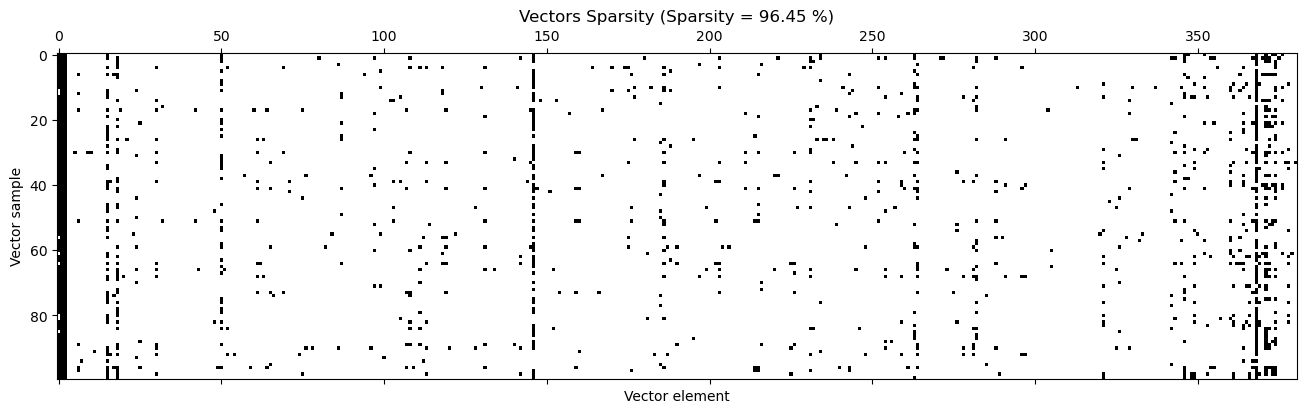

In [17]:
def plot_vector_sparsity(vectors:pd.DataFrame, figsize=(16, 10), n_samples=100):
    filled_entries = vectors.astype(bool).sum().sum()
    overall_sparsity = 1-filled_entries/(vectors.shape[0]*vectors.shape[1])

    fig, ax = plt.subplots(figsize=figsize)
    ax.spy(vectors.sample(n_samples))
    ax.set_title('Vectors Sparsity (Sparsity = {:.02f} %)'.format(100*overall_sparsity))
    ax.set_xlabel('Vector element')
    ax.set_ylabel('Vector sample')
    return fig, ax

plot_vector_sparsity(df_vectors, n_samples=100)

## Análise de variância explicada

Para reduzir a dimensionalidade dos vetores podemos adicionar a classe [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) em nosso pipeline de transformações. 

No entanto, um dos parâmetros fundamentais para a PCA é o **número de componentes principais** que será utiliado após as transformações. Este número de componente define o **tamanho do vetor** a ser utilizado para o cálculo de similaridades.

In [18]:
from sklearn.decomposition import PCA
n_components = df_train.shape[1]

pipeline_pca = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('decomposition', PCA(n_components=n_components))
])

pipeline_pca.fit(df_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('decomposition', PCA(n_components=381))])

Para decidir o número de componentes principais a ser utilizado na PCA podemos fazer uma **análise de variância explicada**: quanto mais componentes principais são utilizados na PCA maior a explicabilidade da variância.

Em geral, podemos considerar um número de componentes principais suficientes para explicar **90%** da variância dos dados de entrada.

(<Figure size 1200x800 with 2 Axes>,
 <AxesSubplot:title={'center':'Cumulative Explained Variance (381 components)'}, xlabel='Principal Components'>)

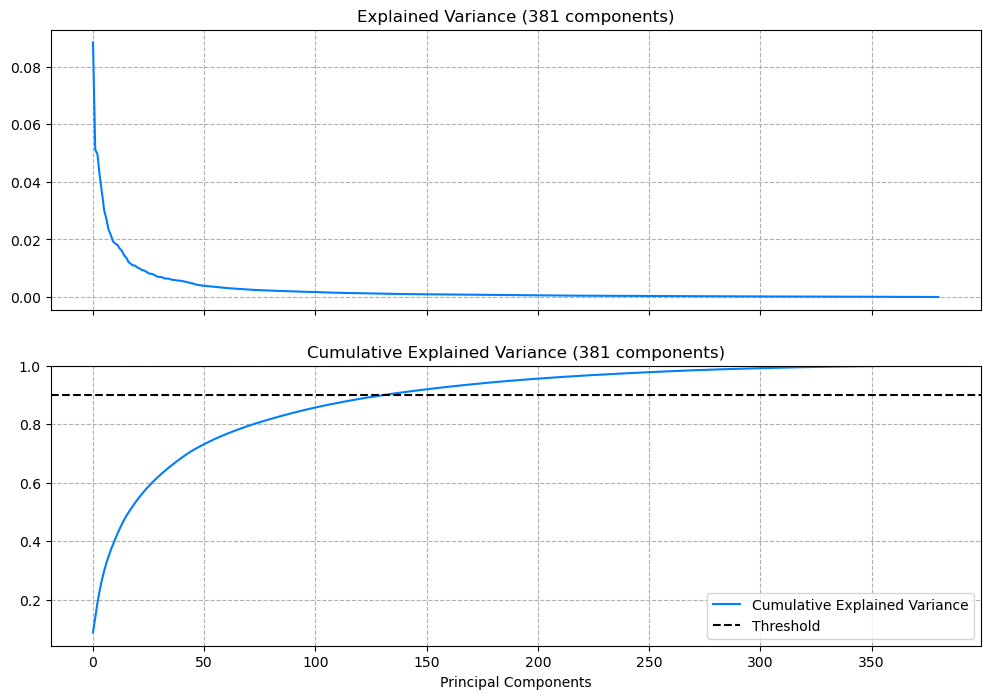

In [19]:
def plot_explained_variance(explained_variance, figsize=(16,8), threshold=0.9, cumulative=True):
    label = 'Explained Variance'
    n_componenents = len(explained_variance)

    fig, axes = plt.subplots(nrows=2, figsize=figsize, sharex=True)

    ax = axes[0]
    ax.plot(explained_variance, label=label)

    ax.set_title(f'{label} ({n_components} components)')

    ax = axes[1]
    label = f'Cumulative {label}'
    ax.plot(np.cumsum(explained_variance), label=label)
    ax.axhline(threshold, c='black', linestyle='--', label='Threshold')
    ax.set_title(f'{label} ({n_components} components)')
    ax.set_xlabel('Principal Components')
    ax.set_ylim(top=1.0)
    ax.legend()
    [ax_i.grid(True, linestyle='--') for ax_i in axes]
    return fig, ax

explained_variance_ratio = pipeline_pca.named_steps['decomposition'].explained_variance_ratio_
plot_explained_variance(explained_variance_ratio, cumulative = False, figsize=(12,8))

## Redução de dimensionalidade

Através da análise gráfica podemos escolher um número de componentes final a ser utilizado para a PCA.

In [20]:
n_components = 150
pipeline_pca = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('decomposition', PCA(n_components=n_components))
])

pipeline_pca.fit(df_train)

df_vectors_pca = generate_vector_representation(pipeline_pca, df_train, keep_columns=False)
df_vectors_pca.tail()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
id,,,,,,,,,,,,,,,,,,,,,
9970,-0.678987,-0.427745,0.392028,-0.143320,-0.671988,0.127962,0.131818,0.266490,-0.766825,-0.197784,...,0.011817,0.027947,-0.019950,-0.016123,-0.017258,-0.005719,0.018338,-0.013146,0.019279,-0.028996
99700,0.045390,-0.225525,-0.615700,0.374983,0.730148,0.123234,1.159890,0.966161,0.532615,0.382058,...,-0.048926,-0.012755,-0.004327,-0.123876,-0.016778,0.087191,-0.016164,-0.046738,-0.021895,-0.015910
9980,-0.854433,-0.377767,-0.552167,0.089070,0.203783,-0.073796,0.816582,-0.242471,0.068920,-0.108289,...,-0.001397,-0.001801,-0.104388,-0.082357,-0.046031,0.088426,-0.036801,-0.050631,0.015321,-0.023475
99900,1.669908,-0.189964,1.205550,0.582277,0.685167,1.183369,0.024355,-1.069412,-0.310266,0.859328,...,-0.116317,0.014444,0.001097,-0.021239,-0.295584,-0.051527,-0.049216,-0.075155,-0.167437,-0.078021
99910,0.239036,-0.474338,0.485375,0.000911,1.173145,0.509232,0.430435,-1.146643,0.524939,0.008349,...,-0.093080,-0.006370,-0.046475,-0.009170,-0.044736,-0.027514,-0.018418,0.008080,-0.044876,-0.004738


In [21]:
print ('Dimensão dos vetores (pré-PCA):', df_vectors.shape[1])
print ('Dimensão dos embeddings (pós-PCA):', df_vectors_pca.shape[1])

Dimensão dos vetores (pré-PCA): 381
Dimensão dos embeddings (pós-PCA): 150


Após a redução de dimensionalidade, podemos rever a esparsidade dos vetores a serem utilizados para o cálculo de similaridade

(<Figure size 1600x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Vectors Sparsity (Sparsity = 0.00 %)'}, xlabel='Vector element', ylabel='Vector sample'>)

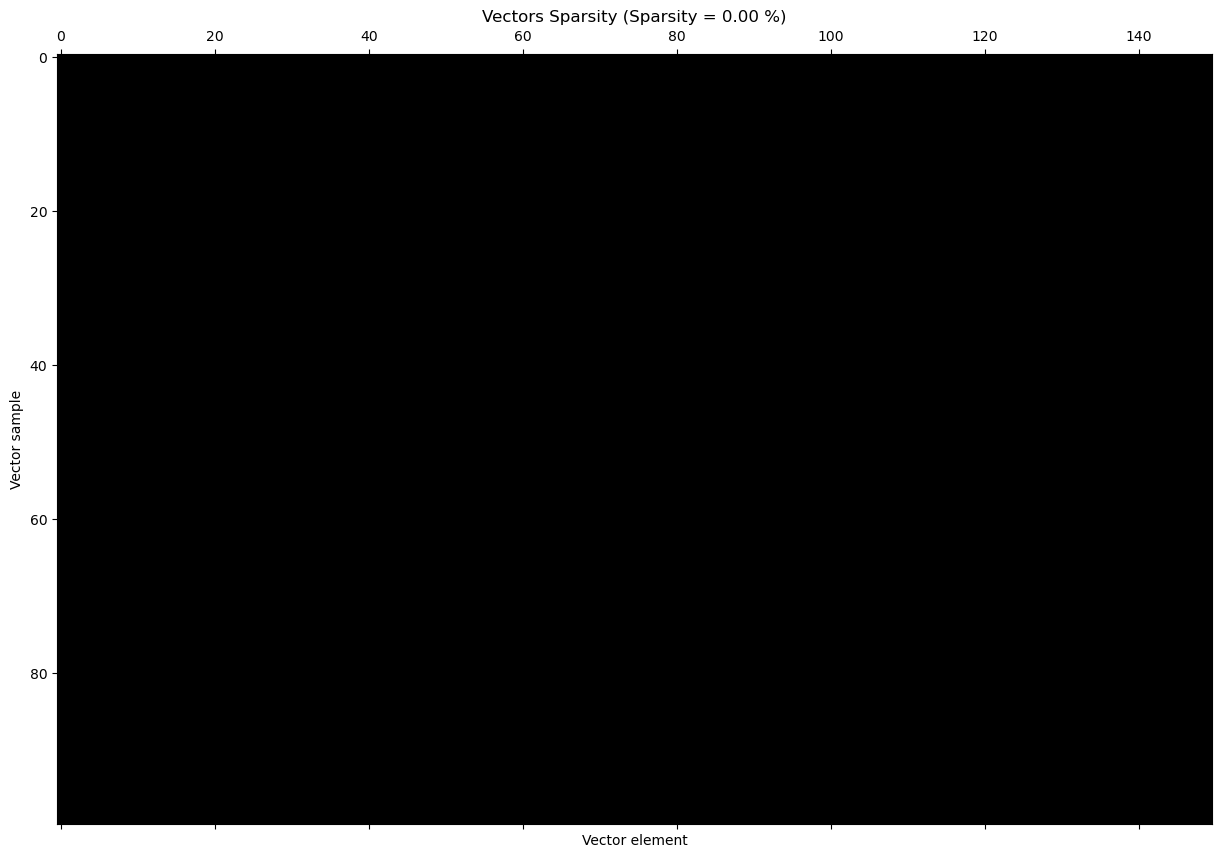

In [22]:
plot_vector_sparsity(df_vectors_pca, n_samples=100)

## Calculando a matriz de similaridades item-item com embeddings

Quando um vetor tem a sua informação compactada chamamos o vetor resultante de **embedding**. Esses embeddings gerados pela PCA podem ser utilizados para o cálculo de similaridade entre os itens de forma análoga ao cálculo com os vetores em representação maximamente esparsa.

In [23]:
# %%time
df_item_similarity_matrix_pca = calculate_similarity_matrix(df_vectors_pca)
df_item_similarity_matrix_pca.shape

(19442, 19442)

## Gerando recomendações com PCA

In [24]:
id = '12180'    # Grand Theft Auto 2
df_recommended_items_pca = recommend_similar_items(df_item_similarity_matrix_pca, id)
display_recommendations(df_recommended_items_pca, df[['title', 'tags']])

,score,title,tags
id,,,
12180,1.000000,Grand Theft Auto 2,"[Action, Classic, Open World, Singleplayer, Sh..."
12170,0.678756,Grand Theft Auto,"[Action, Classic, Open World, Singleplayer, 2D..."
38430,0.587403,Kingpin — Life of Crime,"[Action, FPS, Singleplayer, Crime, Classic, Go..."
2610,0.583664,GUN™,"[Western, Action, Open World, Third-Person Sho..."
40990,0.551678,Mafia,"[Action, Adventure, Violent, Story Rich, Class..."
299050,0.537987,Blood II: The Chosen + Expansion,"[Action, Adventure, FPS, Gore, Classic, Horror..."
6880,0.533131,Just Cause,"[Action, Open World, Shooter, Third Person, Si..."
587650,0.519798,Half-Life 2: DownFall,"[Action, Free to Play, Violent, Gore, Mod, FPS..."
12100,0.518779,Grand Theft Auto III,"[Open World, Action, Classic, Third Person, Si..."


Testando diferentes itens de referência

In [25]:
id = '12180'  # Grand Theft Auto 2 
# id = '10'     # Counter Striker
# id = '221040' # Resident Evil 6
# id = '252950' # Rocket League
# id = '338300' # Disney'Chicken
# id = '226580' # F1
# id = '260210' # Assassin's Creed
df_recommended_items_pca = recommend_similar_items(df_item_similarity_matrix_pca, id)
display_recommendations(df_recommended_items_pca, df[['title', 'tags']])

,score,title,tags
id,,,
12180,1.000000,Grand Theft Auto 2,"[Action, Classic, Open World, Singleplayer, Sh..."
12170,0.678756,Grand Theft Auto,"[Action, Classic, Open World, Singleplayer, 2D..."
38430,0.587403,Kingpin — Life of Crime,"[Action, FPS, Singleplayer, Crime, Classic, Go..."
2610,0.583664,GUN™,"[Western, Action, Open World, Third-Person Sho..."
40990,0.551678,Mafia,"[Action, Adventure, Violent, Story Rich, Class..."
299050,0.537987,Blood II: The Chosen + Expansion,"[Action, Adventure, FPS, Gore, Classic, Horror..."
6880,0.533131,Just Cause,"[Action, Open World, Shooter, Third Person, Si..."
587650,0.519798,Half-Life 2: DownFall,"[Action, Free to Play, Violent, Gore, Mod, FPS..."
12100,0.518779,Grand Theft Auto III,"[Open World, Action, Classic, Third Person, Si..."


In [26]:
id = df.sample().index[0]
df_recommended_items_pca = recommend_similar_items(df_item_similarity_matrix_pca, id)
display_recommendations(df_recommended_items_pca, df[['title', 'tags']])

,score,title,tags
id,,,
725660,1.000000,Thundering Skies,"[Action, Indie]"
726020,0.999974,Mission: Demolition,"[Action, Indie]"
442260,0.988981,Sprinter,"[Action, Indie]"
290440,0.862627,QUALIA 3: Multi Agent,"[Action, Indie, Shoot 'Em Up]"
299800,0.857621,The Land of Eyas,"[Action, Indie, Puzzle-Platformer]"
673280,0.855810,GyroSphere Trials,"[Indie, Action, Racing]"
594810,0.851986,Color Jumper,"[Indie, Action, Platformer]"
744170,0.846539,Starfighter Neon,"[Action, Indie]"
568060,0.846539,Hyper Void,"[Indie, Action]"
